In [31]:
from scipy.integrate import simpson
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq
from scipy.signal import savgol_filter, detrend, windows

import numpy as np
import pandas as pd
import os
import re
from obspy import Trace, Stream

def filter_fourier(data, type, fs, fmin, fmax, order):
	"""Filtra el espectro de fourier a las frecuencias especificadas haciendo uso de la función filter de Obspy
	Solamente usado si no se aplica ninguna otra técnica de suavizamiento. 
	
	NOTA: Este algoritmo es lento y aumenta considerablemente el tiempo de análisis de las señales.

	Args
	---
		- data (ndarray): Arreglo que contiene los datos de aceleracion
		- type (str): Tipo de filtro. {'bandpass','highpass','lowpass'}
		- fmin (float): Frecuencia de corte mínima
		- fmax (float): Frecuencia de corte máxima
		- fs (float): Frecuencia de muestreo
		- order (int): Orden del filtro
	"""
	N = len(data[0])
	traces = []
	for comp in data:
		traces.append(Trace(comp))
	st = Stream(traces=traces)
	stfilter = st.copy()
	freqmin = fmin/fs
	freqmax = fmax/fs
	stfilter.filter(type, freqmin=freqmin, freqmax=freqmax, corners=order, zerophase=True)
	amps = np.array([np.abs(rfft(stf)/(N/2)) for stf in stfilter])
	freq = rfftfreq(N, 1/fs)

	return amps, freq

def extract_spectral(accdata, vel_muestreo):
	"""Calculates frequency-related data

	Args:
		accdata (array): acceleration data
		vel_muestreo (float): sampling rate

	Returns:
		list: list of elements extracted
	"""	
	N = len(accdata[0])

	# Aplica cosine taper
	cos = windows.cosine(N)

	accdata = detrend(accdata - np.mean(accdata))*cos
	accdata_fft = np.abs(rfft(accdata)/(N/2))

	# Aplica filtro savitzky-golay al espectro de Fourier
	accdata_fft = savgol_filter(x=accdata_fft, window_length=len(accdata_fft[0])//50, polyorder=3, axis=-1, mode='constant')

	accdata_freq = rfftfreq(N, 1/vel_muestreo)
	# accdata_fft, accdata_freq = filter_fourier(accdata, type='bandpass', fs=vel_muestreo, fmin=0.1, fmax=10, order=15)
	max_fft_value = np.max(np.max(accdata_fft, axis=-1))

	# max_fft.append(max_fft_value)
	maxfft = max_fft_value

	# Obtiene el valor máximo del espectro fft
	best = np.nanargmax(accdata_fft)
	best_ = np.unravel_index(best, shape=accdata_fft.shape)

	accdata_fft_best = accdata_fft[best_[0]]

	# fft_std.append(np.std(accdata_fft_best))
	stdd = np.std(accdata_fft_best)
	# fft_q50.append(np.quantile(accdata_fft_best, 0.5))
	q50 = np.quantile(accdata_fft_best, 0.5)
	# fft_kurtosis.append(kurtosis(accdata_fft_best))
	kurt = kurtosis(accdata_fft_best)
	# fft_skew.append(skew(accdata_fft_best))
	sk = skew(accdata_fft_best)

	if vel_muestreo != np.nan:
		best_freq = accdata_freq[best_[-1]]
		# max_freq.append(best_freq)
		maxfreq = best_freq
		# area.append(np.trapz(np.abs(accdata[best_[0]]), dx=1/vel_muestreo))
		area = np.trapz(np.abs(accdata[best_[0]]), dx=1/vel_muestreo)
	else:
		# max_freq.append(np.nan)
		maxfreq = np.nan
		# area.append(np.nan)
		area = np.nan

	return [maxfft, stdd, q50, kurt, sk, maxfreq, area]


def extract_data(folder_path):
	"""
	Extrae datos importantes del encabezado 
	"""
	
	count = 0

	clave = []
	lat_estacion = []
	lon_estacion = []
	elev_estacion = []
	tipo_de_suelo = []
	fecha = []
	hora_sismo = []
	magnitud = []
	magnitud_escala = []
	lat_epicentro = []
	lon_epicentro = []
	profundidad_hipocentro = []
	hora_primera_muestra = []
	pga = []
	rumbo = []
	fs = []
	max_fft = []
	max_freq = []
	max_freq_unfiltered = []
	calidad = []
	area = []
	fft_std = []
	fft_q50 = []
	fft_kurtosis = []
	fft_skew = []
	channels = []
	path = []
	institucion = []

	files = os.listdir(folder_path)
	filecount = 0
	for file in files:
		filecount += 1
		if filecount % 10 == 0:
			print(f'Leyendo archivo {filecount}/{len(files)}')
		
		count = 0
		full_path = os.path.join(folder_path, file)
		# un accdata por cada archivo
		accdata = np.loadtxt(full_path, unpack=True, skiprows=109)

		#! Descarta la señal si más del 20% de los valores son ceros
		if (accdata==0).sum() >= np.size(accdata)*0.2:
			continue
		
		maxpga = np.max(np.abs(accdata.ravel()))
		pga.append(maxpga)
		N = len(accdata[0])

		# Itera cada línea del archivo
		with open(full_path) as f:
			for line in f:
				count += 1
				if count == 17:  # Clave de la estación
					clave.append(line.split(":")[-1].strip())
				
				elif count == 23:  # latitud de la estación
					lat_estacion.append(float(line.split(":")[-1].strip().split()[0].strip()))

				elif count == 24:  # Longitud de la estación
					lon_estacion.append(-float(line.split(":")[-1].strip().split()[0].strip()))
				
				elif count == 25: # Elevación de la estación (msnm)
					try:
						elev_estacion.append(float(line.split(":")[-1].strip().split()[0].strip()))
					except:
						elev_estacion.append(np.nan)

				elif count == 26:  # Suelo
					tipo_de_suelo.append(line.split(":")[-1].strip().capitalize())
				
				elif count == 29: # Institucion responsable
					institucion.append(line.split(":")[-1].strip())

				elif count == 37: # Rumbo-orientacion de los sensores
					rumbo.append(line.split(":")[-1].strip().split("/")[1:])

				elif count == 39: # Velocidad de muestreo
					try: # verifica que haya informacion despues de ":"
						split = line.split(":")[-1]
						vel_muestreo = split.strip().split("/")[1:][0]
						try:
							vel_muestreo = float(vel_muestreo)
							fs.append(vel_muestreo)
						except ValueError:
							continue
					except IndexError: # asigna un valor arbitrario tipo str para que el siguiente ciclo entre en efecto
						vel_muestreo = split

				elif count == 47 and not isinstance(vel_muestreo, float): # Intervalo de muestreo
					# entra en este ciclo solamente si no se pudo obtener informacion directamente de la velocidad de muestreo. Toma el valor del intervalo de muestreo y lo convierte.
					# En caso de no contar con intervalo de muestreo tampoco, devuelve NaN
					try:
						intervalo_muestreo = line.split(":")[-1].strip().split("/")[1:][0]
						try:
							intervalo_muestreo = float(intervalo_muestreo)
							vel_muestreo = 1/intervalo_muestreo
							fs.append(vel_muestreo)
						except ValueError:
							vel_muestreo = np.nan
							fs.append(vel_muestreo)
					except IndexError:
						vel_muestreo = np.nan
						fs.append(vel_muestreo)

				elif count == 57:  # Fecha
					fecha.append(line.split(":")[-1].strip())

				elif count == 58:  # hora del sismo
					hora = line.split(":", 1)[-1].strip()
					if ',' in hora:
						hora = hora.replace(',','.')
					if len(hora.split(":")) > 3:
						parts = hora.split(":")
						hora = ":".join(parts[:3]) + '.' + parts[-1]
					hora_sismo.append(hora)
				
				# Introduction to seismology - Peter M. Shearer (2009) p. 285
				# MS agrees approximately with MW at magnitudes between about 6.5 and 7.5
				elif count == 59:  # Magnitud
						# Busca y da preferencia a la magnitud superficial Ms
					mags = line.split(":")[-1].strip()
					options = ['M','Mb','Ms','Mc','Me','Ma']
					for option in options:
						match = re.search(fr"\b{option}\b=(\d+(?:\.\d+)?)", mags)
						if match:
							if float(match.group(1)) == 0:
								continue
							else:
								magnitud.append(float(match.group(1)))
								magnitud_escala.append(option)
								break
					if not match:
						print(mags)
						raise ValueError('Magnitude not found')

				elif count == 60:  # Latitud del epicentro
					string = line.split(":")[-1].strip().split()[0].strip()
					try:
						lat_epicentro.append(float(string))
					except ValueError:
						match = re.search(r'\d+\.\d+', string)
						match = float(match.group())
						lat_epicentro.append(match)

				elif count == 61:  # Longitud del epicentro
					string = line.split(":")[-1].strip().split()[0].strip()
					try:
						lon_epicentro.append(-float(string))
					except ValueError:
						match = re.search(r'\d+\.\d+', string)
						match = float(match.group())
						lon_epicentro.append(-match)

				elif count == 62:  # Profundidad del hipocentro
					profundidad_hipocentro.append(float(line.split(":")[-1].strip()))

				elif count == 68: # Hora de la primera muestra
					hora = line.split(":", 1)[-1].strip()
					if ',' in hora:
						hora = hora.replace(',','.')
					if len(hora.split(":")) > 3:
						parts = hora.split(":")
						hora = ":".join(parts[:3]) + '.' + parts[-1]
					elif len(hora.split(":")) == 3:
						hora = hora
					else:
						hora = '-'
					hora_primera_muestra.append(hora)

				elif count == 85: # Calidad
					if 'AL QUE FALTA UNA PARTE' in line:
						calidad.append('J')
					elif 'CARECE DE TIEMPO ABSOLUTO' in line:
						calidad.append('B')
					elif 'REGISTRO DIGITAL COMPLETO' and 'CON TIEMPO ABSOLUTO CORRECTO' in line:
						calidad.append('A')
					elif 'REGISTRO INCOMPLETO EN SU PARTE INTENSA' in line:
						calidad.append('X')
					else:	
						calidad.append('S/C')
				
				elif count == 108: # Canales disponibles
					channels.append([ch.strip() for ch in line.split()])
			
			maxfft, stdd, q50, kurt, sk, maxfreq, areaa = extract_spectral(accdata=accdata, vel_muestreo=vel_muestreo)
			max_fft.append(maxfft)
			fft_std.append(stdd)
			fft_q50.append(q50)
			fft_kurtosis.append(kurt)
			fft_skew.append(sk)
			max_freq.append(maxfreq)
			area.append(areaa)
			
			count = 0  # Reinicia el conteo de líneas para cada archivo
			# Se almacena el accdata del archivo aún dentro del while
			# Esta función se coloca dentro del while porque depende del valor de vel_muestreo
		path.append(full_path)



	data = pd.DataFrame({'Clave': clave,
					  'Institucion': institucion,
					  'Fecha': fecha,
					  'Hora': hora_sismo,
					  'Hora_primera_muestra': hora_primera_muestra,
					  'Magnitud': magnitud,
					  'Escala_magnitud': magnitud_escala,
					  'Calidad': calidad,
					  'Lat_estacion': lat_estacion,
					  'Lon_estacion': lon_estacion,
					  'Elev_estacion': elev_estacion,
					  'Lat_epicentro': lat_epicentro,
					  'Lon_epicentro': lon_epicentro,
					  'Suelo': tipo_de_suelo,
					  'Profundidad': profundidad_hipocentro,
					  'PGA_Gal': pga,
					#   'Rumbo-orientacion': rumbo,
					  })
	
	lat1 = data['Lat_estacion']
	lon1 = data['Lon_estacion']
	lat2 = data['Lat_epicentro']
	lon2 = data['Lon_epicentro']

	data['Fecha'] = data['Fecha'] + ' ' + data['Hora']
	data.drop(columns='Hora', inplace=True)	
	data['Distancia_km'] = np.sqrt(np.abs(lat1-lat2)**2 + np.abs(lon1-lon2)**2)*111.194926
	data['Canales'] = channels
	data['area_integral'] = area
	data['Fs_hz'] = fs
	data['FFT_AmpMax'] = max_fft
	data['FFTFreq_AmpMax'] = max_freq
	data['FFT_power'] = data['FFT_AmpMax']**2 # potencia espectral

	data['FFT_std'] = fft_std # desviacion estandar
	data['FFT_q50'] = fft_q50 # cuantil 50 (valor <= media)
	data['FFT_kurtosis'] = fft_kurtosis
	data['FFT_skew'] = fft_skew
	data['Filepath'] = path
	
	return data



def stack_df(path):
	"""
	Join the dataframes into a single one

	"""
	dflist = []

	for file in os.listdir(path):
		if file.endswith('.csv'):
			filepath = os.path.join(path, file)
			df = pd.read_csv(filepath)
			dflist.append(df)
	stacked = pd.concat(dflist, axis=0, ignore_index=True)

	return stacked

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the haversine distance between two sets of latitude and longitude coordinates.
    Inputs should be NumPy arrays.
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers (mean value)
    r = 6371.0  # Earth radius in kilometers
    # Calculate the distance
    distance = r * c
    return distance


In [32]:
folder = r"C:\Users\huevo\Downloads\Archivos_Acc"

# Around 2 min at full power
# total = extract_data(folder)
# total.to_csv(r'C:\Users\huevo\Documents\GeofisicaFIUNAM\Tesis\DATOS\Unprocessed.csv')

In [33]:
total = pd.read_csv(r'C:\Users\huevo\Documents\GeofisicaFIUNAM\Tesis\DATOS\Unprocessed.csv', index_col=0)
total.shape

(2710, 27)

In [34]:
suelos_replace = {'Alto riesgo sï¿½smico':'Alto riesgo sismico',
				  'Terreno blando, material compresible,':'Terreno blando, material compresible',
				  'Alto riesgo sísmico':'Alto riesgo sismico',
				  'Transiciï¿½n':'Transicion',
				  'Transición':'Transicion',
				  'Arenoso limoso, compacto':'Arenoso, limoso, compacto',
				  'Terreno estratificado (arcillas,':'Terreno estratificado'}
total = total.replace(suelos_replace)
total['Suelo'].value_counts()

Roca                                    955
Terreno blando, material compresible    257
Arcilloso, zona lago                    168
Alto riesgo sismico                     151
Arcilla                                 136
Aluvial                                  85
Arenoso, limoso, compacto                80
Suelo                                    75
Blando                                   66
Suelo blando                             65
Roca basaltica                           63
Transicion                               52
?                                        41
Roca, cantera                            34
Suelo aluvial                            32
Basalto                                  30
Suelo duro                               28
Terreno estratificado                    28
Limo arenoso                             27
Deposito barra                           24
Terreno firme, materiales compactos      24
Roca sedimentaria                        24
Estructura                      

In [35]:
s = 'HORA DE LA PRIMERA MUESTRA (GMT)       : '
hora = s.split(":", 1)[-1].strip()
print(len(hora.split(":")))
if ',' in hora:
	print('rep')
	hora = hora.replace(',','.')
if len(hora.split(":")) > 3:
	parts = hora.split(":")
	hora = ":".join(parts[:3]) + '.' + parts[-1]
	print('1',hora)
elif len(hora.split(":")) == 3:
	hora = hora
	print('2',hora)
else:
	hora = '-'
	print('3',hora)

1
3 -


In [36]:
month_abbreviations = {
    'ENE': 'Jan',  # Enero - January
    'FEB': 'Feb',  # Febrero - February
    'MAR': 'Mar',  # Marzo - March
    'ABR': 'Apr',  # Abril - April
    'MAY': 'May',  # Mayo - May
    'JUN': 'Jun',  # Junio - June
    'JUL': 'Jul',  # Julio - July
    'AGO': 'Aug',  # Agosto - August
    'SEP': 'Sep',  # Septiembre - September
    'OCT': 'Oct',  # Octubre - October
    'NOV': 'Nov',  # Noviembre - November
    'DIC': 'Dec'   # Diciembre - December
}

for i, fecha in enumerate(total['Fecha']):
	for k, v in month_abbreviations.items():
		if k in fecha:
			total.loc[i,'Fecha'] = total.loc[i, 'Fecha'].replace(k, v)
total['Fecha'] = pd.to_datetime(total.Fecha, errors='coerce', dayfirst=True)
			

In [37]:
total['Hora_primera_muestra'] = pd.to_datetime(total.Fecha.dt.date.astype(str) + ' ' + total.Hora_primera_muestra, errors='coerce', dayfirst=True)

In [38]:
total['Dist_hipocentro'] = np.sqrt(total.Distancia_km**2 + total.Profundidad**2)
total[total['FFTFreq_AmpMax'] > 20].sort_values('FFTFreq_AmpMax', ascending=False).reset_index(drop=True)

,Clave,Institucion,Fecha,Hora_primera_muestra,Magnitud,Escala_magnitud,Calidad,Lat_estacion,Lon_estacion,Elev_estacion,...,Fs_hz,FFT_AmpMax,FFTFreq_AmpMax,FFT_power,FFT_std,FFT_q50,FFT_kurtosis,FFT_skew,Filepath,Dist_hipocentro
0,NUX2,INSTITUTO DE INGENIERIA UNAM,2013-04-05 01:58:48.000,2013-04-05 01:58:02.000,5.3,M,A,17.216711,-100.791170,10.0,...,200.0,0.324458,28.946154,0.105273,0.061792,0.025454,3.153202,1.741140,C:\Users\huevo\Downloads\Archivos_Acc\NUX21304...,23.029645
1,OMTP,INSTITUTO DE INGENIERIA UNAM,1999-06-15 20:42:07.100,1999-06-15 20:42:08.000,6.4,Mb,A,16.689000,-98.398000,300.0,...,200.0,0.119569,26.519055,0.014297,0.030125,0.007397,-0.447200,0.885704,C:\Users\huevo\Downloads\Archivos_Acc\OMTP9906...,204.933330
2,SMR2,INSTITUTO DE INGENIERIA UNAM,2001-10-08 03:39:19.300,2001-10-08 03:38:27.000,5.6,Mb,A,16.773510,-99.437700,80.0,...,200.0,0.087587,25.051625,0.007671,0.019852,0.000902,2.601971,1.811578,C:\Users\huevo\Downloads\Archivos_Acc\SMR20110...,80.356185
3,SMR2,INSTITUTO DE INGENIERIA UNAM,1999-06-15 20:42:07.100,1999-06-15 20:42:10.810,6.4,Mb,A,16.773510,-99.437700,80.0,...,200.0,0.070384,24.475606,0.004954,0.014854,0.000341,3.689545,2.030444,C:\Users\huevo\Downloads\Archivos_Acc\SMR29906...,274.164868
4,XALT,INSTITUTO DE INGENIERIA UNAM,1992-01-09 04:03:18.800,1992-01-09 04:03:23.030,4.7,Mb,A,17.095000,-99.720000,560.0,...,200.0,0.311768,21.669279,0.097200,0.053652,0.005585,8.836844,2.999331,C:\Users\huevo\Downloads\Archivos_Acc\XALT9201...,34.305753
5,COMD,INSTITUTO DE INGENIERIA UNAM,2012-11-15 09:20:22.000,2012-11-15 09:19:39.000,6.1,M,A,18.122359,-100.523804,306.0,...,200.0,0.263103,20.733696,0.069223,0.054537,0.010129,2.003538,1.670411,C:\Users\huevo\Downloads\Archivos_Acc\COMD1211...,40.351478
6,OMTP,INSTITUTO DE INGENIERIA UNAM,2004-06-14 22:54:21.300,2004-06-14 22:54:27.000,5.6,Mb,A,16.689000,-98.398000,300.0,...,200.0,0.260739,20.303788,0.067985,0.052751,0.012426,1.130436,1.268466,C:\Users\huevo\Downloads\Archivos_Acc\OMTP0406...,59.329844


In [39]:
total['Canales'] = [it.replace("'","").replace("[","").replace("]","").strip().split(",") for it in total['Canales']]

max_columns = max([len(lst) for lst in total.Canales])
for i in range(max_columns):
    total[f'Canal_{i+1}'] = total['Canales'].apply(lambda x: x[i] if len(x) > i else np.nan)

def replace_values(value):
    if value is np.nan:
        return "-"
    elif "00" in value or "OO" in value or "T" in value:
        return "BHN"
    elif "90" in value or "L" in value:
        return "BHE"
    elif "V" in value or "Z" in value:
        return "BHZ"
    else:
        return value

# Apply replacement rules to each newly created column
for i in range(max_columns):
    total[f'Canal_{i+1}'] = total[f'Canal_{i+1}'].apply(replace_values)

In [40]:
# df.loc[[35,1098, 1099,1236, 1237,883,1127],'Calidad'] = 'X'
total[total['Calidad'] == 'S/C']

,Clave,Institucion,Fecha,Hora_primera_muestra,Magnitud,Escala_magnitud,Calidad,Lat_estacion,Lon_estacion,Elev_estacion,...,Dist_hipocentro,Canal_1,Canal_2,Canal_3,Canal_4,Canal_5,Canal_6,Canal_7,Canal_8,Canal_9
1,ACAC,INSTITUTO DE INGENIERIA UNAM,2003-01-22 02:06:34.500,2003-01-22 02:08:38.000,6.5,Mb,S/C,16.848510,-99.851570,5.0,...,523.413415,BHZ,BHE,BHN,-,-,-,-,-,-
2,ACAC,INSTITUTO DE INGENIERIA UNAM,2007-04-13 05:42:22.000,2007-04-13 05:42:03.000,6.3,M,S/C,16.848510,-99.851570,5.0,...,81.750816,BHN,BHZ,BHE,-,-,-,-,-,-
20,ACAC,INSTITUTO DE INGENIERIA UNAM,1995-09-14 14:04:30.500,1995-09-14 14:04:56.000,6.4,Mb,S/C,16.848510,-99.851570,5.0,...,125.462482,BHZ,BHE,BHN,-,-,-,-,-,-
24,ACAD,INSTITUTO DE INGENIERIA UNAM,2007-04-13 05:42:22.000,2007-04-13 05:42:04.000,6.3,M,S/C,16.862250,-99.871470,6.0,...,79.490937,BHZ,BHE,BHN,-,-,-,-,-,-
25,ACAD,INSTITUTO DE INGENIERIA UNAM,2007-11-06 06:35:42.000,2007-11-06 06:35:32.000,5.6,M,S/C,16.862250,-99.871470,6.0,...,39.481956,BHZ,BHE,BHN,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603,VIGA,INSTITUTO DE INGENIERIA UNAM,2021-09-08 01:47:46.000,2021-09-08 01:47:30.000,7.1,M,S/C,16.758703,-99.233268,35.0,...,78.151670,BHZ,HNN,HNE,-,-,-,-,-,-
2607,VIGA,INSTITUTO DE INGENIERIA UNAM,1995-09-14 14:04:30.500,1995-09-14 14:04:44.670,6.4,Mb,S/C,16.758703,-99.233268,30.0,...,67.204210,BHE,BHZ,BHN,-,-,-,-,-,-
2641,VNTA,INSTITUTO DE INGENIERIA UNAM,2021-09-08 01:47:46.000,2021-09-08 01:47:30.000,7.1,M,S/C,16.914260,-99.818850,50.0,...,21.808912,BHZ,HNN,HNE,-,-,-,-,-,-
2695,XP06,CIRES,1993-09-10 19:12:57.000,1993-09-10 19:16:55.470,7.2,Mc,S/C,19.420000,-99.135000,2232.0,...,883.316982,BHN,BHZ,BHE,-,-,-,-,-,-


In [41]:
print(total.shape)

replaces = {'Arcillosa, zona lago': 'Arcilloso, zona lago',
			'?': 'No clasificado',
			'Sin informacion': 'No clasificado',
			'Suelo blando':'Blando',
			'Terreno blando':'Blando',
			'Arena - limo - arcilla':'Arena-limo-arcilla',
			'Granite':'Granito',
			'Zona de transicion':'Transicion',
			'Zona de lago':'Arcilloso, zona lago',
			'Basalto':'Roca basaltica',
			'Roca granitica':'Granito',
			'Suelo aluvial': 'Aluvial',
			'"Roca, cantera"': 'Roca, cantera'}

total['Suelo'].fillna('No clasificado', inplace=True)
total.replace(replaces, inplace=True)
total['Suelo'].value_counts()
len(total['Fecha'].unique())
suelo = total['Suelo'].to_list()

suelo_new = ['Arcilla' if 'cill' in s else s for s in suelo]
suelo_new = ['Roca' if 'oca' in s else s for s in suelo_new]
suelo_new = ['Estructura' if 'structura' in s else s for s in suelo_new]
suelo_new = ['Trancision' if 'rancisi' in s else s for s in suelo_new]
total['Suelo'] = suelo_new
total['Escala_magnitud'] = total['Escala_magnitud'].replace('M', 'Mw')
print(total.shape)


(2710, 37)
(2710, 37)


## M? a Mw

Se utilizan las relaciones empíricas obtenidas por este señor https://www.nature.com/articles/s41597-019-0234-z/tables/3

In [42]:
def unify(data):
	if data.Escala_magnitud == 'Ms':
		return (5.58) - (0.68)*data.Magnitud + (0.13-0.01)*data.Magnitud**2
	elif data.Escala_magnitud == 'Mb':
		return (-1.36+0.13) + (1.35-0.15)*data.Magnitud
	elif data.Escala_magnitud == 'Mc':
		return (-0.31) + (1.06)*data.Magnitud
	else:
		return data.Magnitud
	
total['Mw*'] = total.apply(unify, axis=1)
# total.plot(x='Magnitud', y='Mw*',kind='scatter')
total[total['Mw*'] < 0]
total[['Magnitud','Escala_magnitud','Mw*']].head()


,Magnitud,Escala_magnitud,Mw*
0,5.6,Mb,5.49
1,6.5,Mb,6.57
2,6.3,Mw,6.30
3,6.6,Mw,6.60
4,5.7,Mw,5.70


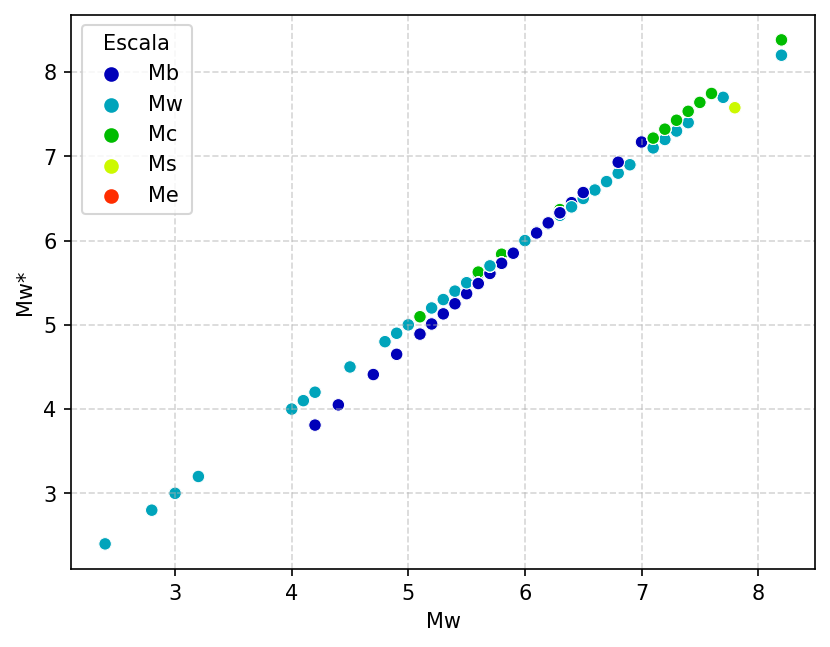

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=total, x='Magnitud', y='Mw*', hue='Escala_magnitud', palette='nipy_spectral')
plt.legend(title='Escala')
plt.grid(ls='--', alpha=0.5)
plt.xlabel('Mw')

plt.gcf().set_dpi(150)

plt.savefig(r'C:\Users\huevo\Documents\GeofisicaFIUNAM\Tesis\LaTeX Modelos ML Tesis\Fig\Mw_unif.pdf', format='pdf')
plt.show()

## Mecanismo focal de ***algunos*** sismos

In [44]:
fm = pd.read_excel(r'C:\Users\huevo\Documents\GeofisicaFIUNAM\Tesis\DATOS\Earthquake catalog focal mechanisms.xlsx', header=0)
# fm['date'] = [pd.to_datetime(d).date() for d in fm.Date]
# fm['time'] = [pd.to_datetime(d).time() for d in fm.Date]
fm['date'] = pd.to_datetime(fm['Date'])
fm = fm[['date','Strike 1','Dip 1','Rake 1']].sort_values(by='date')

# total['date'] = [pd.to_datetime(d).date() for d in total.Fecha]
# total['time'] = [pd.to_datetime(d).time() for d in total.Fecha]
total['date'] = pd.to_datetime(total['Fecha'])
total = total.sort_values(by='date')

# total = total[['date','time','Lat_epicentro','Lon_epicentro','Mw*','Profundidad']]
tolerance = pd.Timedelta(seconds=59)

merged = pd.merge_asof(total, fm, on='date', tolerance=tolerance, direction='nearest')

merged.to_csv(r'C:\Users\huevo\Documents\GeofisicaFIUNAM\Tesis\DATOS\Datos_completo_FM.csv')
print(merged.shape, total.shape)
print(merged.isna().sum())
# merged

(2710, 42) (2710, 39)
Clave                     0
Institucion               0
Fecha                     0
Hora_primera_muestra     52
Magnitud                  0
Escala_magnitud           0
Calidad                   0
Lat_estacion              0
Lon_estacion              0
Elev_estacion            35
Lat_epicentro             0
Lon_epicentro             0
Suelo                     0
Profundidad               0
PGA_Gal                   0
Distancia_km              0
Canales                   0
area_integral             0
Fs_hz                     0
FFT_AmpMax                0
FFTFreq_AmpMax            0
FFT_power                 0
FFT_std                   0
FFT_q50                   0
FFT_kurtosis              0
FFT_skew                  0
Filepath                  0
Dist_hipocentro           0
Canal_1                   0
Canal_2                   0
Canal_3                   0
Canal_4                   0
Canal_5                   0
Canal_6                   0
Canal_7                   

In [45]:
total = total.reindex(columns = [col for col in total.columns if col != 'Filepath'] + ['Filepath'])


path = r'C:\Users\huevo\Documents\GeofisicaFIUNAM\Tesis\DATOS\Datos_completo.csv'
if os.path.exists(path):
	os.remove(path)

total = total.drop(columns=['Elev_estacion'])
total.to_csv(path, index=False)
total.shape

(2710, 38)